In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models,layers
from tensorflow import keras
from tensorflow import feature_column
from sklearn import metrics
from sklearn.model_selection import train_test_split
import seaborn as sb

In [3]:
path = "/content/drive/MyDrive/Colab Notebooks/Final Dataset.csv"
initial = pd.read_csv(path)
initial

,Node,Mobility,Mobility_speed,packet_Received,packet_Sent,Forwarding_Difference,Energy,num_Received,num_Sent,packet_Drop,Transmission_Power,Attack_type,Type_of_node
0,R0,RandomWayPoint,4,37,10,161,-1.138122,1217,1056,0,1.4,Normal,Normal
1,R1,RandomWayPoint,4,26,2,0,-0.198993,0,0,0,1.4,Normal,Normal
2,R2,RandomWayPoint,4,34,4,0,-0.206068,0,0,0,1.4,Normal,Normal
3,R3,RandomWayPoint,4,21,2,0,-0.164678,0,0,0,1.4,Normal,Normal
4,R4,RandomWayPoint,4,17,2,0,-0.168908,0,0,0,1.4,Normal,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2270,R20,Mass,12,1190,208,207,-0.355682,600,393,13,1.4,UDP Flooding DOS,Normal
2271,R21,Mass,12,933,233,67,-0.549195,633,566,21,1.4,UDP Flooding DOS,Normal
2272,R22,Mass,12,885,233,40,-0.431493,326,286,12,1.4,UDP Flooding DOS,Normal
2273,A,Mass,12,1064,2204,-477,-0.939987,88,565,36,1.4,UDP Flooding DOS,Normal


In [4]:
print(initial.columns)

Index(['Node', 'Mobility', 'Mobility_speed', 'packet_Received', 'packet_Sent',
       'Forwarding_Difference', 'Energy', 'num_Received', 'num_Sent',
       'packet_Drop', 'Transmission_Power', 'Attack_type', 'Type_of_node'],
      dtype='object')


In [5]:
initial.isnull().sum()

Node                     0
Mobility                 0
Mobility_speed           0
packet_Received          0
packet_Sent              0
Forwarding_Difference    0
Energy                   0
num_Received             0
num_Sent                 0
packet_Drop              0
Transmission_Power       0
Attack_type              0
Type_of_node             0
dtype: int64

In [6]:
initial.Type_of_node = initial.Type_of_node.replace({'Normal':0, 'Attacker':1})

In [7]:
print(initial['Attack_type'].unique())
print(initial['Mobility'].unique())
print(initial.dtypes)

['Normal' 'Blackhole' 'Hello Flooding' 'UDP Flooding DOS']
['RandomWayPoint' 'Mass']
Node                      object
Mobility                  object
Mobility_speed             int64
packet_Received            int64
packet_Sent                int64
Forwarding_Difference      int64
Energy                   float64
num_Received               int64
num_Sent                   int64
packet_Drop                int64
Transmission_Power       float64
Attack_type               object
Type_of_node               int64
dtype: object


In [8]:
initial.Attack_type = initial.Attack_type.replace({'Normal':0, 'Blackhole':1, 'Hello Flooding':2, 'UDP Flooding DOS':3})
initial.Mobility = initial.Mobility.replace({'Mass':0, 'RandomWayPoint':1})

In [9]:
initial

,Node,Mobility,Mobility_speed,packet_Received,packet_Sent,Forwarding_Difference,Energy,num_Received,num_Sent,packet_Drop,Transmission_Power,Attack_type,Type_of_node
0,R0,1,4,37,10,161,-1.138122,1217,1056,0,1.4,0,0
1,R1,1,4,26,2,0,-0.198993,0,0,0,1.4,0,0
2,R2,1,4,34,4,0,-0.206068,0,0,0,1.4,0,0
3,R3,1,4,21,2,0,-0.164678,0,0,0,1.4,0,0
4,R4,1,4,17,2,0,-0.168908,0,0,0,1.4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2270,R20,0,12,1190,208,207,-0.355682,600,393,13,1.4,3,0
2271,R21,0,12,933,233,67,-0.549195,633,566,21,1.4,3,0
2272,R22,0,12,885,233,40,-0.431493,326,286,12,1.4,3,0
2273,A,0,12,1064,2204,-477,-0.939987,88,565,36,1.4,3,0


In [10]:
# Partitioning data
# Setting x and y
# features=list(initial.columns)
# cols=list(set(features)-set(['Node','Position', 'Mobility_model', 'Type_of_node']))
# print(cols)
cols = ['Mobility', 'Mobility_speed', 'packet_Received', 'packet_Sent',
       'Forwarding_Difference', 'Energy', 'num_Received', 'num_Sent',
       'packet_Drop', 'Transmission_Power', 'Attack_type']

x=np.array(initial[cols].values)
y=np.array(initial['Type_of_node'].values)

#Splitting data into training set and test set
train_data,test_data,train_target,test_target = train_test_split(x,y,test_size=0.1,random_state=1)
print(train_data.shape,"\t",train_target.shape)
print(test_data.shape,"\t",test_target.shape)

(2047, 11) 	 (2047,)
(228, 11) 	 (228,)


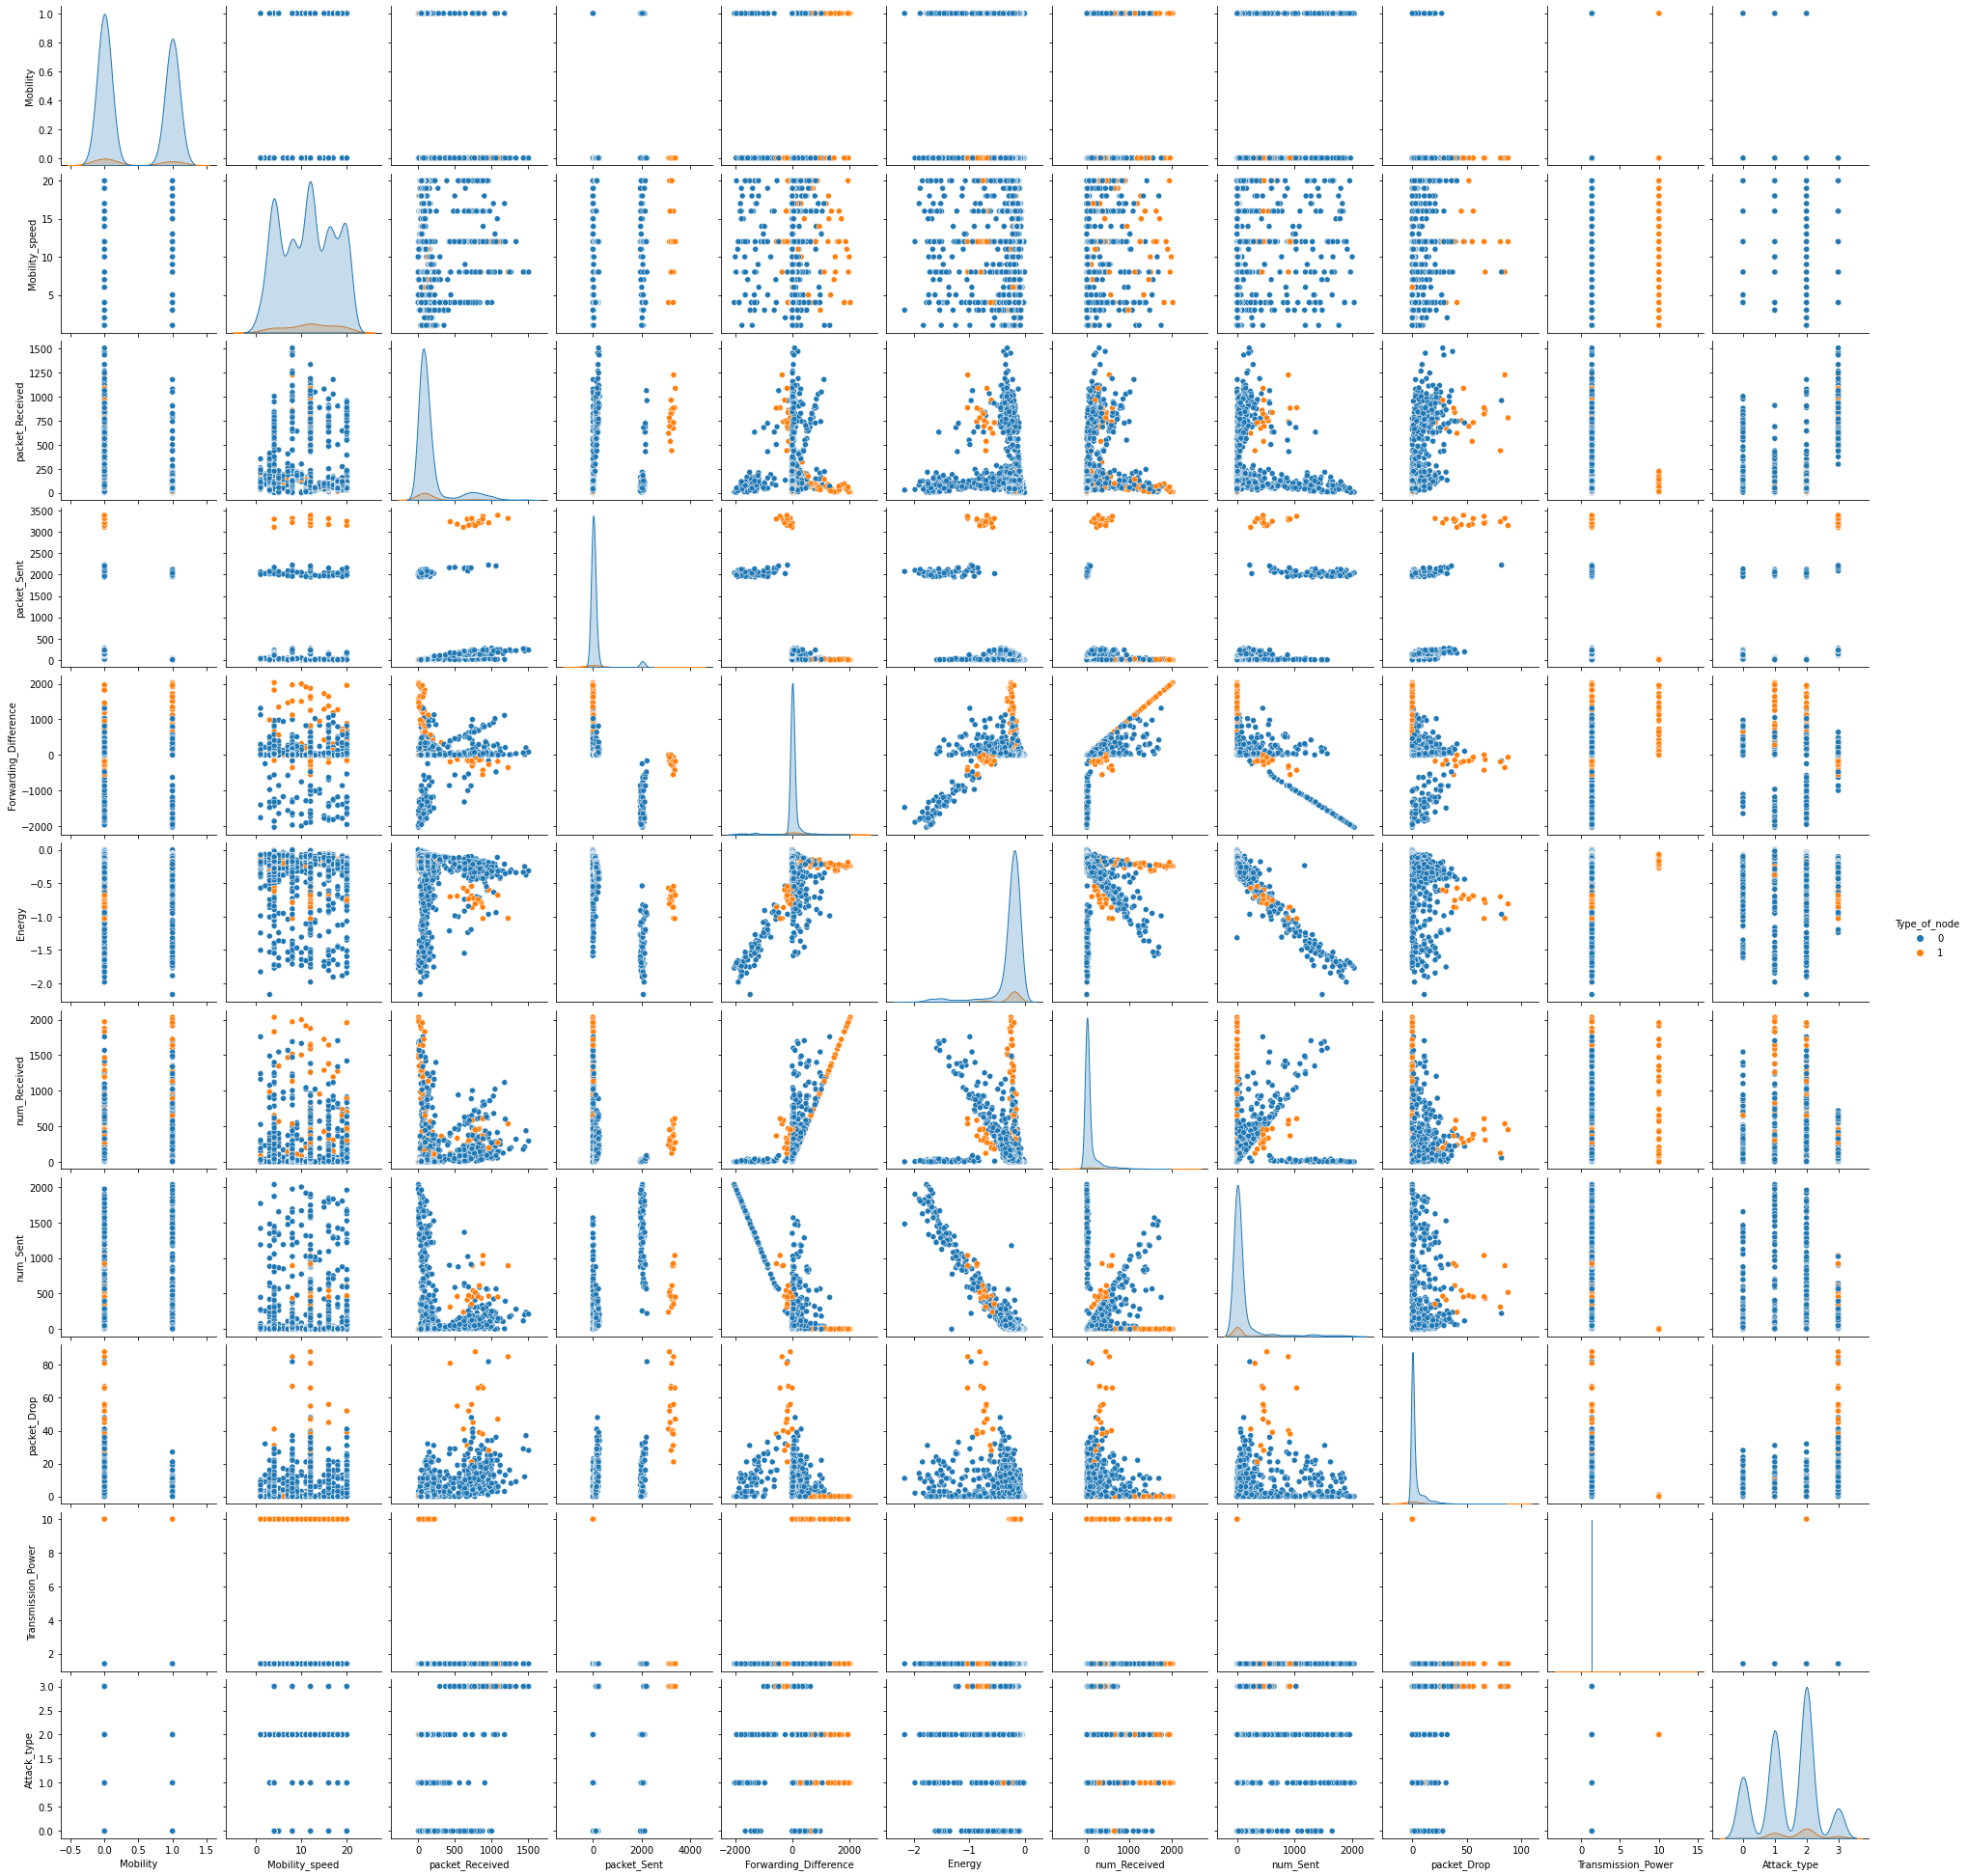

In [11]:
# Inspecting the dataset
# sb.pairplot(initial[["Sent_packets","Received_packets","Transmission_Power_mW","Packet_Delivery_Ratio","Energy_Consumption"]],
            # diag_kind="kde",hue="initial["Type_of_node"]")

sb.pairplot(initial,hue='Type_of_node')
plt.show()

In [12]:
# To check the corealtion between the features
initial.corr()

,Mobility,Mobility_speed,packet_Received,packet_Sent,Forwarding_Difference,Energy,num_Received,num_Sent,packet_Drop,Transmission_Power,Attack_type,Type_of_node
Mobility,1.000000,0.036856,-0.329774,-0.080579,-0.002238,-0.034268,-0.015754,-0.011488,-0.246313,0.001503,-0.215638,-0.039196
Mobility_speed,0.036856,1.000000,-0.015383,0.002169,-0.000962,-0.037185,-0.011727,-0.009365,0.020399,0.002084,-0.025178,0.024328
packet_Received,-0.329774,-0.015383,1.000000,0.200353,0.087693,-0.074573,0.189838,0.068121,0.595976,-0.058204,0.435036,0.011693
packet_Sent,-0.080579,0.002169,0.200353,1.000000,-0.648007,-0.746082,0.002227,0.752177,0.569524,-0.045888,0.132300,0.158042
Forwarding_Difference,-0.002238,-0.000962,0.087693,-0.648007,1.000000,0.597733,0.550387,-0.665852,-0.110029,0.151132,0.001240,0.249909
Energy,-0.034268,-0.037185,-0.074573,-0.746082,0.597733,1.000000,-0.296670,-0.957092,-0.340782,0.065996,-0.002340,0.015589
num_Received,-0.015754,-0.011727,0.189838,0.002227,0.550387,-0.296670,1.000000,0.256436,0.178645,0.126784,0.027602,0.295442
num_Sent,-0.011488,-0.009365,0.068121,0.752177,-0.665852,-0.957092,0.256436,1.000000,0.287017,-0.061667,0.023231,-0.025306
packet_Drop,-0.246313,0.020399,0.595976,0.569524,-0.110029,-0.340782,0.178645,0.287017,1.000000,-0.072270,0.322435,0.137198
Transmission_Power,0.001503,0.002084,-0.058204,-0.045888,0.151132,0.065996,0.126784,-0.061667,-0.072270,1.000000,0.118508,0.733711


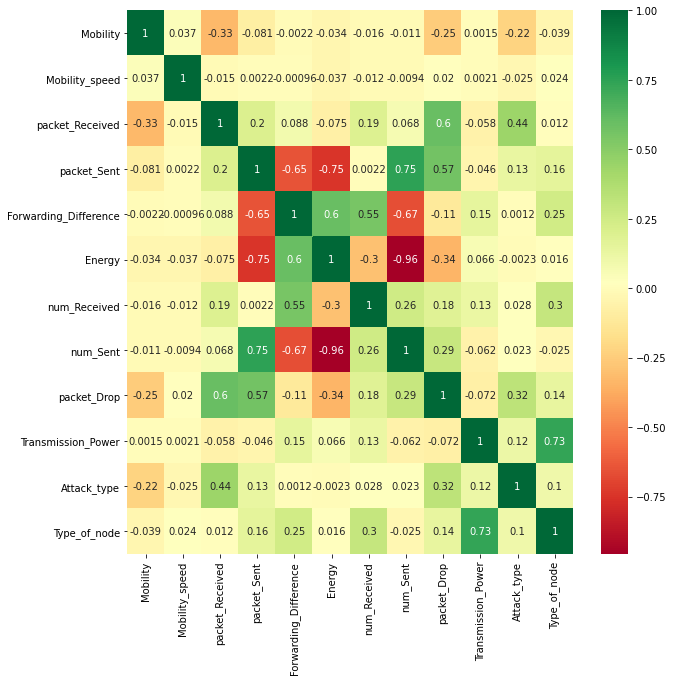

In [13]:
heatmap = initial.corr()
top_feat = heatmap.index
plt.figure(figsize=(10,10))
p = sb.heatmap(initial[top_feat].corr(),annot=True,cmap ='RdYlGn')

In [14]:
print(train_data[0])
print(train_data.shape[1])

[ 1.       1.      57.      16.       0.      -0.07286  0.       0.
  0.       1.4      2.     ]
11


In [15]:
#Created model
model=tf.keras.Sequential([
  layers.Dense(32,activation='relu',input_shape=[train_data.shape[1]]),
  layers.Dense(64,activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(32,activation='relu'),
  layers.Dense(8,activation='relu'),
  layers.Dense(1,activation='sigmoid')])
model.summary()
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['mse','accuracy'])
# print(train_1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                384       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 4,849
Trainable params: 4,849
Non-trainable params: 0
______________________________________________________

In [16]:
example_batch = train_data[:10]
example_result = model.predict(example_batch)
print(example_result)

[[0.9018006]
 [1.       ]
 [0.961885 ]
 [1.       ]
 [0.9832674]
 [1.       ]
 [0.9575359]
 [0.9997722]
 [0.8104565]
 [1.       ]]


In [17]:
store=model.fit(train_data, train_target, validation_split=0.15, epochs=100, batch_size=32,
                 callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)])
model.summary()

Epoch 1/100
55/55 [==============================] - 1s 5ms/step - loss: 2.0276 - mse: 0.1434 - accuracy: 0.8453 - val_loss: 0.2027 - val_mse: 0.0315 - val_accuracy: 0.9708
Epoch 2/100
55/55 [==============================] - 0s 2ms/step - loss: 0.4988 - mse: 0.0663 - accuracy: 0.9385 - val_loss: 0.1325 - val_mse: 0.0296 - val_accuracy: 0.9740
Epoch 3/100
55/55 [==============================] - 0s 2ms/step - loss: 0.3270 - mse: 0.0607 - accuracy: 0.9425 - val_loss: 0.1116 - val_mse: 0.0247 - val_accuracy: 0.9773
Epoch 4/100
55/55 [==============================] - 0s 2ms/step - loss: 0.3565 - mse: 0.0559 - accuracy: 0.9419 - val_loss: 0.1015 - val_mse: 0.0244 - val_accuracy: 0.9740
Epoch 5/100
55/55 [==============================] - 0s 2ms/step - loss: 0.2606 - mse: 0.0485 - accuracy: 0.9488 - val_loss: 0.0931 - val_mse: 0.0217 - val_accuracy: 0.9773
Epoch 6/100
55/55 [==============================] - 0s 2ms/step - loss: 0.2659 - mse: 0.0457 - accuracy: 0.9523 - val_loss: 0.0927 - v

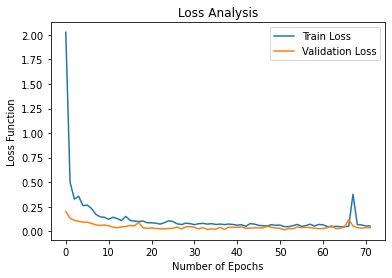

In [18]:
# Plotting validation loss and training loss

history_df = pd.DataFrame(store.history)
history_df['epoch']=store.epoch
plt.figure()
plt.title("Loss Analysis")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss Function")
plt.plot(history_df['epoch'], history_df['loss'], label="Train Loss")
plt.plot(history_df['epoch'], history_df['val_loss'], label="Validation Loss")
plt.legend()
plt.show()

In [19]:
test_loss, test_mse, test_acc1 = model.evaluate(test_data, test_target)
print('Test Accuracy:',test_acc1)

8/8 [==============================] - 0s 2ms/step - loss: 0.0671 - mse: 0.0189 - accuracy: 0.9781
Test Accuracy: 0.9780701994895935


In [20]:
test_answers = model.predict_classes(test_data)
cols = ['Mobility', 'Mobility_speed', 'packet_Received', 'packet_Sent',
       'Forwarding_Difference', 'Energy', 'num_Received', 'num_Sent',
       'packet_Drop', 'Transmission_Power', 'Attack_type']
       
test_df = pd.DataFrame(test_data, columns = cols)
test_df['Type_of_node'] = test_answers
test_df

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


,Mobility,Mobility_speed,packet_Received,packet_Sent,Forwarding_Difference,Energy,num_Received,num_Sent,packet_Drop,Transmission_Power,Attack_type,Type_of_node
0,0.0,17.0,81.0,2034.0,-1817.0,-1.904590,11.0,1828.0,14.0,1.4,2.0,0
1,1.0,20.0,105.0,19.0,0.0,-0.256808,1.0,1.0,0.0,1.4,0.0,0
2,0.0,8.0,144.0,17.0,0.0,-0.092380,0.0,0.0,0.0,1.4,2.0,0
3,0.0,20.0,100.0,19.0,37.0,-0.241400,40.0,3.0,0.0,10.0,2.0,1
4,1.0,9.0,204.0,30.0,6.0,-0.295570,19.0,13.0,4.0,1.4,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
223,0.0,4.0,755.0,129.0,3.0,-0.128647,78.0,75.0,4.0,1.4,0.0,0
224,1.0,16.0,37.0,9.0,10.0,-0.450602,268.0,258.0,0.0,1.4,0.0,0
225,0.0,8.0,157.0,34.0,1020.0,-0.623530,1203.0,183.0,22.0,1.4,2.0,0
226,1.0,19.0,44.0,6.0,0.0,-0.171500,0.0,0.0,0.0,1.4,2.0,0


In [24]:
# Confusion Matrix for test dataset
cf1 = metrics.confusion_matrix(test_target, test_answers)
print(cf1)
# Thus in binary classification, the count of true negatives is , false negatives is , true positives is  and false positives is .

[[210   4]
 [  1  13]]
